In [1]:
import os
import random
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob

In [2]:
def get_annotation_files(annotation_dir):
    return glob.glob(os.path.join(annotation_dir, "*.xml"))

def get_images(image_dir):
    return glob.glob(os.path.join(image_dir, "*.jpg"))

def get_background_images(background_dir):
    return glob.glob(os.path.join(background_dir, "*.jpg"))

def get_bounding_boxes_and_classes(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    bounding_boxes = []
    classes = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        classes.append(class_name)

        bndbox_xml = obj.find('bndbox')
        xmin = int(bndbox_xml.find('xmin').text)
        ymin = int(bndbox_xml.find('ymin').text)
        xmax = int(bndbox_xml.find('xmax').text)
        ymax = int(bndbox_xml.find('ymax').text)

        bounding_boxes.append((xmin, ymin, xmax, ymax))

    return bounding_boxes, classes

def extract_objects(image_path, bounding_boxes):
    image = Image.open(image_path)

    objects = []
    for bbox in bounding_boxes:
        obj = image.crop(bbox)
        objects.append(obj)

    return objects

def get_random_background(backgrounds):
    return random.choice(backgrounds)

def get_random_position(background, obj):
    print(f'{background.width}, {background.height}')
    print(f'{obj.width}, {obj.height}')
    max_x = background.width - obj.width
    max_y = background.height - obj.height
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    return x, y

def composite(background_path, obj, class_name, original_image_path, output_dir, index):
    original_image = Image.open(original_image_path)
    original_size = original_image.size

    background = Image.open(background_path)
    background_size = background.size

    # 배경의 크기의 1/3 이상이 되도록 객체의 크기를 조정합니다.
#     max_dim_background = max(background.size)
    new_size_object = (background.width // 3, background.height // 3)

    obj = obj.resize(new_size_object)

    # 객체가 배경 이미지의 중앙에 위치하도록 합니다.
#     position = ((background_size[0] - new_size_object[0]) // 2, (background_size[1] - new_size_object[1]) // 2)
    position = get_random_position(background, obj)
    background.paste(obj, position)

    # 새로운 바운딩 박스 정보를 계산합니다.
    xmin, ymin = position
    xmax, ymax = xmin + new_size_object[0], ymin + new_size_object[1]

    # 바운딩 박스 정보를 XML 파일로 저장합니다.
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "filename").text = os.path.basename(original_image_path)
    object_xml = ET.SubElement(annotation, "object")
    ET.SubElement(object_xml, "name").text = class_name  # 객체의 클래스 이름을 추가합니다.
    bndbox = ET.SubElement(object_xml, "bndbox")
    ET.SubElement(bndbox, "xmin").text = str(xmin)
    ET.SubElement(bndbox, "ymin").text = str(ymin)
    ET.SubElement(bndbox, "xmax").text = str(xmax)
    ET.SubElement(bndbox, "ymax").text = str(ymax)

    tree = ET.ElementTree(annotation)
    tree.write(os.path.join(output_dir, os.path.basename(original_image_path).replace(".jpg", f"_{index}.xml")))

    # 이미지를 저장합니다.
    background.save(os.path.join(output_dir, os.path.basename(original_image_path).replace(".jpg", f"_{index}.jpg")))

    return background

In [3]:
def get_annotation_files(annotation_dir):
    return glob.glob(os.path.join(annotation_dir, "*.xml"))

def get_images(image_dir):
    return glob.glob(os.path.join(image_dir, "*.jpg"))

def get_background_images(background_dir):
    return glob.glob(os.path.join(background_dir, "*.jpg"))

def get_random_background(background_paths):
    return random.choice(background_paths)

def get_bounding_boxes(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    bounding_boxes = []
    classes = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        classes.append(class_name)

        bndbox_xml = obj.find('bndbox')
        xmin = int(bndbox_xml.find('xmin').text)
        ymin = int(bndbox_xml.find('ymin').text)
        xmax = int(bndbox_xml.find('xmax').text)
        ymax = int(bndbox_xml.find('ymax').text)

        bounding_boxes.append((xmin, ymin, xmax, ymax))

    return bounding_boxes, classes

def extract_objects(image_path, bounding_boxes):
    image = Image.open(image_path)
    obj = [image.crop(box) for box in bounding_boxes]
    return obj

def get_random_position(background, obj):
    max_x = background.width - obj.width
    max_y = background.height - obj.height
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    return x, y

# def composite(background_path, object, original_image_path):
#     original_image = Image.open(original_image_path)
#     original_size = original_image.size

#     background = Image.open(background_path)
#     background = background.resize(original_size)
    
#     position = get_random_position(background, object)
#     background.paste(object, position)
#     return background

def composite(background_path, obj, original_image_path):
    original_image = Image.open(original_image_path)
    original_size = original_image.size

    background = Image.open(background_path)
    background_size = background.size
    
    # 배경의 크기의 1/3 이상이 되도록 객체의 크기를 조정합니다.
    max_dim_background = max(background.size)
    new_size_object = (max_dim_background // 3, max_dim_background // 3)
    
    obj = obj.resize(new_size_object, Image.ANTIALIAS)

    position = get_random_position(background, obj)
    background.paste(obj, position)
    return background

def save_bounding_box_to_xml(image_path, bounding_box, save_path):
    # 바운딩 박스 정보를 XML 파일로 저장합니다.
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "filename").text = os.path.basename(original_image_path)
    object_xml = ET.SubElement(annotation, "object")
    ET.SubElement(object_xml, "name").text = class_name  # 객체의 클래스 이름을 추가합니다.
    bndbox = ET.SubElement(object_xml, "bndbox")
    ET.SubElement(bndbox, "xmin").text = str(xmin)
    ET.SubElement(bndbox, "ymin").text = str(ymin)
    ET.SubElement(bndbox, "xmax").text = str(xmax)
    ET.SubElement(bndbox, "ymax").text = str(ymax)

    tree = ET.ElementTree(annotation)
    tree.write(os.path.join(output_dir, os.path.basename(original_image_path).replace(".jpg", ".xml")))

In [ ]:
annotation_files = get_annotation_files('D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations/')
image_files = get_images('D:/dataset/PASCAL_VOC_2007/VOC2007/JPEGImages/')
background_files = get_background_images('D:/dataset/landscape/')

index = 1
# 모든 이미지 파일에 대해 반복합니다.
for image_file, annotation_file in zip(image_files, annotation_files):
    # 각 이미지의 바운딩 박스 정보와 클래스 정보를 추출합니다.
    bounding_boxes, classes = get_bounding_boxes_and_classes(annotation_file)

    # 바운딩 박스 정보를 이용하여 객체를 분리합니다.
    objects = extract_objects(image_file, bounding_boxes)
    
    # 각 객체에 대해 반복합니다.
    for i, obj in enumerate(objects):
        # 랜덤한 배경 이미지를 가져옵니다.
        backgrounds = [os.path.join('D:/dataset/landscape/', file) for file in os.listdir('D:/dataset/landscape/')]

        # 분리된 객체를 랜덤한 풍경 이미지에 합성하고 저장합니다.
        output_dir = 'D:/dataset/synth_data'
        os.makedirs(output_dir, exist_ok=True)
        composite_image = composite(get_random_background(backgrounds), objects[i], classes[i], image_file, output_dir, index)
        index += 1
        # 합성된 이미지를 시각화합니다.
        plt.imshow(np.array(composite_image))
        plt.show()

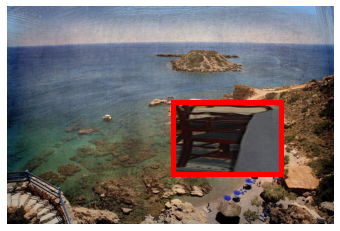

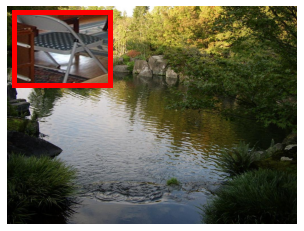

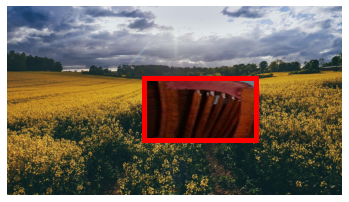

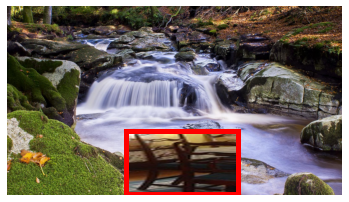

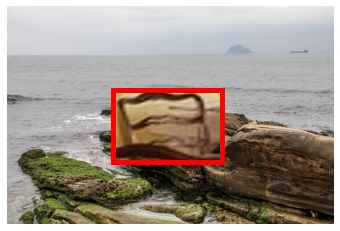

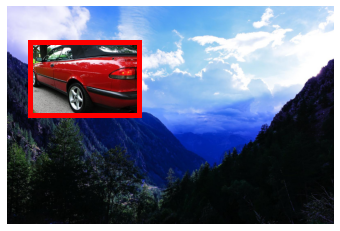

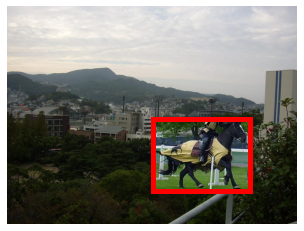

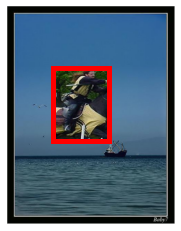

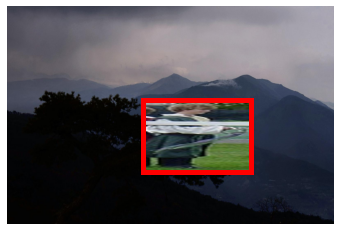

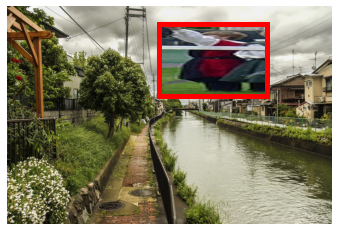

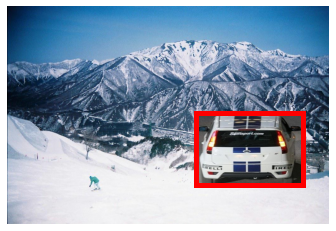

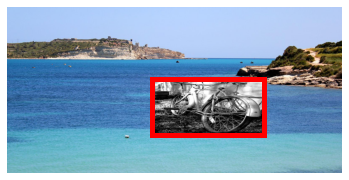

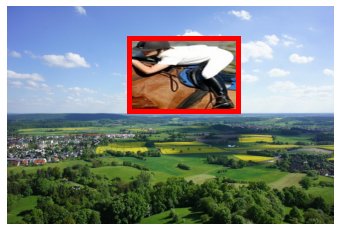

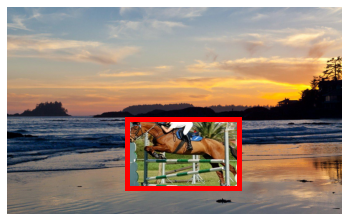

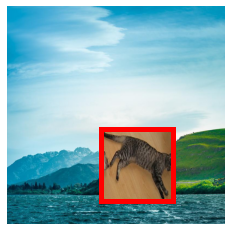

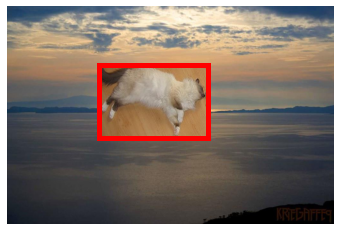

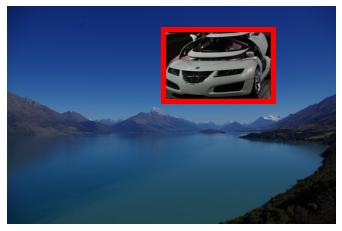

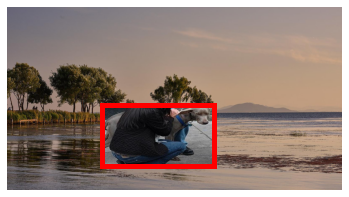

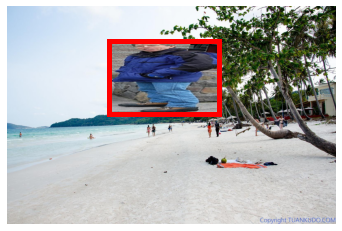

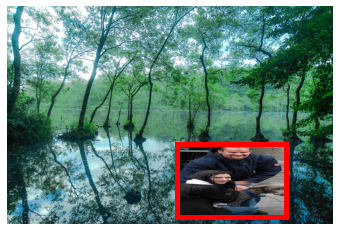

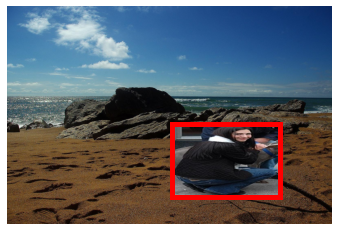

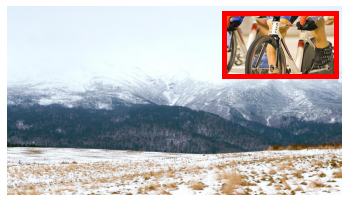

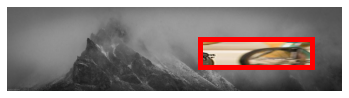

KeyboardInterrupt: 

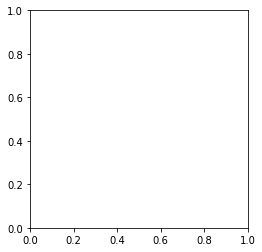

In [7]:
def draw_bounding_boxes(image_path, annotation_path):
    # 이미지를 불러옵니다.
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # 어노테이션 파일을 파싱합니다.
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # 각 객체에 대해 바운딩 박스를 그립니다.
    for object in root.findall('object'):
        bndbox = object.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=5, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

# 이미지와 어노테이션 파일이 있는 디렉토리
directory = "D:\dataset\synth_data"

for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(directory, filename)
        annotation_path = os.path.join(directory, filename.replace(".jpg", ".xml"))
        
        if os.path.isfile(annotation_path):
            draw_bounding_boxes(image_path, annotation_path)


In [12]:
test_data_list = []
class_dir = "D:/dataset/PASCAL_VOC_2007/VOC2007/test"

In [15]:
for cls in os.listdir(class_dir):
    test_data_list.extend(os.listdir(f"{class_dir}/{cls}"))

In [19]:
data_dir = "D:\dataset\synth_data"

In [20]:
os.listdir(data_dir)

['000001_1.jpg',
 '000001_1.xml',
 '000001_2.jpg',
 '000001_2.xml',
 '000002_3.jpg',
 '000002_3.xml',
 '000003_4.jpg',
 '000003_4.xml',
 '000003_5.jpg',
 '000003_5.xml',
 '000004_10.jpg',
 '000004_10.xml',
 '000004_11.jpg',
 '000004_11.xml',
 '000004_12.jpg',
 '000004_12.xml',
 '000004_6.jpg',
 '000004_6.xml',
 '000004_7.jpg',
 '000004_7.xml',
 '000004_8.jpg',
 '000004_8.xml',
 '000004_9.jpg',
 '000004_9.xml',
 '000005_13.jpg',
 '000005_13.xml',
 '000005_14.jpg',
 '000005_14.xml',
 '000005_15.jpg',
 '000005_15.xml',
 '000005_16.jpg',
 '000005_16.xml',
 '000005_17.jpg',
 '000005_17.xml',
 '000006_18.jpg',
 '000006_18.xml',
 '000006_19.jpg',
 '000006_19.xml',
 '000006_20.jpg',
 '000006_20.xml',
 '000006_21.jpg',
 '000006_21.xml',
 '000006_22.jpg',
 '000006_22.xml',
 '000006_23.jpg',
 '000006_23.xml',
 '000006_24.jpg',
 '000006_24.xml',
 '000006_25.jpg',
 '000006_25.xml',
 '000007_26.jpg',
 '000007_26.xml',
 '000008_27.jpg',
 '000008_27.xml',
 '000009_28.jpg',
 '000009_28.xml',
 '000009_2

In [23]:
for test in test_data_list:
    if test.split(".")[0] in os.listdir(data_dir):
        print(test)

KeyboardInterrupt: 

In [32]:
for data in os.listdir(data_dir):
    for test_data in test_data_list:
        if test_data.split(".")[0] in data:
            os.remove(os.path.join(data_dir, data))
            break